In [323]:
import wikipedia
import pandas as pd
from bs4 import BeautifulSoup
import requests

import cv2
import sklearn
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

import os
import json

from sklearn.cluster import KMeans

from colour_segmentation.base.segmentation_algorithm import SegmentationAlgorithm
from colour_segmentation.segmentator import Segmentator

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

# Look at data for Renoir's paintings - especially the colours

Uses this [Wikipedia list](https://en.wikipedia.org/wiki/List_of_paintings_by_Pierre-Auguste_Renoir). We'll parse the tables for each decade and get the data. We'll download all the original files of the paintings.

We'll also extract the colours from each painting to cluster them.

In [527]:
# Read the page and its HTML

page = wikipedia.page('List of paintings by Pierre-Auguste Renoir')
html = page.html()

# Read the list of Renoir's paintings by decade one by one
# note there's two more tables at the bottom, they're not interesting to this
page_tables = pd.read_html(html)[0:6]

# separate DFs by decade
df_1860s, df_1870s, df_1880s, df_1890s, df_1900s, df_1910s = page_tables

In [528]:
# manually removing one from 1870 as it doesn't have an image file
df_1870s = df_1870s[df_1870s.Title != 'Conversation with the Gardener']

In [529]:
# the above doesn't give the URLs of images attached to painting titles
# (the "Picture" field is NaN), those are in the images field of the page but they're not in order
# page.images

# so we shall use BeautifulSoup directly to parse those and attach to the dfs
soup = BeautifulSoup(html, 'lxml') # Parse the HTML as a string

# these are the decade tables
table_1860, table_1870, table_1880, table_1890, table_1900, table_1910 = soup.find_all('table')[0:6]

# and here we get the HREFs to the imgs for each
images = table_1860.find_all('a', class_='image')
df_1860s['original_filename'] = [image.find('img')['src'].split('thumb/')[1].split('.jpg')[0] + '.jpg'
                                 for image in images]

images = table_1870.find_all('a', class_='image')
df_1870s['original_filename'] = [image.find('img')['src'].split('thumb/')[1].split('.jpg')[0] + '.jpg' 
                                 for image in images]

images = table_1880.find_all('a', class_='image')
df_1880s['original_filename'] = [image.find('img')['src'].split('thumb/')[1].split('.jpg')[0] + '.jpg' 
                                 for image in images]

images = table_1890.find_all('a', class_='image')
df_1890s['original_filename'] = [image.find('img')['src'].split('thumb/')[1].split('.jpg')[0] + '.jpg' 
                                 for image in images]

images = table_1900.find_all('a', class_='image')
df_1900s['original_filename'] = [image.find('img')['src'].split('thumb/')[1].split('.jpg')[0] + '.jpg' 
                                 for image in images]

images = table_1910.find_all('a', class_='image')
df_1910s['original_filename'] = [image.find('img')['src'].split('thumb/')[1].split('.jpg')[0] + '.jpg' 
                                 for image in images]


<ipython-input-529-f81d2c631541>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1870s['original_filename'] = [image.find('img')['src'].split('thumb/')[1].split('.jpg')[0] + '.jpg'


In [530]:
#images[-1]
#images[-1].find('img')['src'].split('thumb/')[1].split('.jpg')[0]

In [535]:
df_1860s

,Picture,Title,Year,Dimensions,Museum,original_filename
0,NaN,Portrait of Renoir's Mother,1860,45 cm × 36 cm (18 in × 14 in),Private collection,6/65/Pierre-Auguste_Renoir_-_Portrait_de_la_m%...
1,NaN,Mademoiselle Romaine Lacaux,1864,81.3 cm × 65 cm (32.0 in × 25.6 in),"Cleveland Museum of Art, Cleveland, Ohio, U.S.[4]",b/bb/Romaine_Lacaux%2C_by_Pierre-Auguste_Renoi...
2,NaN,Portrait of Alfred Sisley,1864,81 cm × 65 cm (32 in × 26 in),"Foundation E.G. Bührle, Zürich [5]",6/60/Pierre-Auguste_Renoir_110.jpg
3,NaN,Portrait of William Sisley(fr:Portrait de Will...,1864,81.5 cm × 65.5 cm (32.1 in × 25.8 in),"Musée d'Orsay, Paris, France",5/51/Pierre-Auguste_Renoir_-_William_Sisley.jpg
4,NaN,Lise Sewing,1866,55.88 cm × 45.72 cm (22.00 in × 18.00 in),"Dallas Museum of Art, Texas",4/4a/Lise_Sewing_-_1866.jpg
5,NaN,Mother Anthony's Tavern,1866,194 cm × 131 cm (76 in × 52 in),"Nationalmuseum, Stockholm",1/1f/Renoir_mother_anthonys_tavern_1866.JPG/10...
6,NaN,Madame Joseph Le Coeur,1866,116 cm × 89.5 cm (45.7 in × 35.2 in),"Musée d'Orsay, Paris [6]",7/79/REnoir_Madame_Joseph_Le_Coeur.gif/100px-R...
7,NaN,Lise with a Parasol,1867,184 cm × 115 cm (72 in × 45 in),"Museum Folkwang, Essen, Germany[7]",f/ff/Renoir_Lise_With_Umbrella.jpg
8,NaN,Frédéric Bazille at his Easel,1867,105 cm × 73.5 cm (41.3 in × 28.9 in),"Musée Fabre, Montpellier, France[8]",6/6a/Pierre-Auguste_Renoir_-_Fr%C3%A9d%C3%A9ri...
9,NaN,Diana,1866,197 cm × 132 cm (78 in × 52 in),"National Gallery of Art, Washington, DC",c/c2/Pierre-Auguste_Renoir_020.jpg


# Now download all imgs

Download the original files, from wikimedia. Filenames need prefixed. The lookup for the filename to use and how to build the URL to it has been investigated and tested.

If there's any that doesn't get downloaded (e.g for cases where it's not a .jpg) I try fix manually. Or leave it be if I can't.

In [76]:
base_url ='https://upload.wikimedia.org/wikipedia/commons/'

# # need to spoof it as a browser user agent otherwise wikimedia 
# r = requests.get('https://upload.wikimedia.org/wikipedia/commons/6/65/Pierre-Auguste_Renoir_-_Portrait_de_la_m%C3%A8re_de_Renoir.jpg', 
#                  headers={'User-agent': 'Mozilla/5.0'})


# do one at a time - it's relatively slow
for index, row in df_1910s.iterrows():
    img_url = base_url + row['original_filename']
    print(img_url)
    r = requests.get(img_url, headers={'User-agent': 'Mozilla/5.0'})
    f = open('renoir_1910/' + row['Title'] + '.jpeg', 'wb')
    f.write(r.content)
    f.close()


https://upload.wikimedia.org/wikipedia/commons/9/91/Renoir%27s_Nude.jpg


303194

https://upload.wikimedia.org/wikipedia/commons/6/6f/The_Coast_at_Cagnes%2C_Sea%2C_Mountains_-_Renoir.jpg


126855

https://upload.wikimedia.org/wikipedia/commons/d/d3/Renoir_Self-Portrait_1910.jpg


978990

https://upload.wikimedia.org/wikipedia/commons/c/ce/Renoir18.jpg


30621

https://upload.wikimedia.org/wikipedia/commons/2/2b/Pierre-Auguste_Renoir_113.jpg


457079

https://upload.wikimedia.org/wikipedia/commons/5/50/Pierre-Auguste_Renoir_-_Autoportrait_5.JPG/100px-Pierre-Auguste_Renoir_-_Autoportrait_5.JPG.jpg


162

https://upload.wikimedia.org/wikipedia/commons/b/b6/Pierre-Auguste_Renoir_030.jpg


488742

https://upload.wikimedia.org/wikipedia/commons/f/fd/Ambroise_Vollard_avec_un_foulard_rouge.jpg


7819670

https://upload.wikimedia.org/wikipedia/commons/f/f9/The_Farm_at_Les_Collettes%2C_Cagnes_MET_DT215205.jpg


5139046

https://upload.wikimedia.org/wikipedia/commons/3/39/Pierre-Auguste_Renoir_-_Baigneuse_assise_s%27essuyant_une_jambe.jpg


56602

https://upload.wikimedia.org/wikipedia/commons/6/64/Pierre-Auguste_Renoir_-_Femmes_au_bain.jpg


1699909

https://upload.wikimedia.org/wikipedia/commons/7/75/Pierre-Auguste_Renoir_-_Blonde_%C3%A0_la_rose_-_c._1915-17.jpg


3106305

https://upload.wikimedia.org/wikipedia/commons/d/d8/Ambroise_Vollard_by_Pierre-Auguste_Renoir.jpg


5338594

https://upload.wikimedia.org/wikipedia/commons/3/35/Pierre_Auguste_Renoir_Les_baigneuses.jpg


191898

https://upload.wikimedia.org/wikipedia/commons/5/54/Pierre-Auguste_Renoir_-_Le_Concert.jpg


1746164

https://upload.wikimedia.org/wikipedia/commons/d/dd/Pierre-Auguste_Renoir_-_Ad%C3%A8le_Besson.jpg


1233808

https://upload.wikimedia.org/wikipedia/commons/9/9c/Pierre-Auguste_Renoir_125.jpg


542573

https://upload.wikimedia.org/wikipedia/commons/6/60/Pierre-auguste-Renoir-Madeleine-Leaning-on-Her-Elbow-with-Flowers-in-Her-Hair.jpg


93603

https://upload.wikimedia.org/wikipedia/commons/7/7b/Pierre-Auguste_Renoir_Landschaft.jpg


579011

In [88]:
len(df_1910s)

19

In [87]:
!ls renoir_1910/ | wc -l

      18


## Now investigate the colours!

Using a k-means with 5 clusters asked for for each picture

In [237]:
%%time

kmeans = KMeans(n_clusters=20)

# do one by one
dir_ = 'renoir_1890/'
d = {}

for filename in os.listdir(dir_):
    
    try:
    
        print(filename)

        img = io.imread(dir_ + filename)

        # resize (to half dimensions) so to reduce data, for speed
        img = cv2.resize(img, (0,0), fx=0.2, fy=0.2)
        img = np.reshape(img, (img.shape[0]*img.shape[1], 3))

        kmeans.fit(img)

        d[filename] = {'centroids': kmeans.cluster_centers_.tolist(),
                       'labels': kmeans.labels_.tolist()}
        
    # there can be some in wrong format    
    except:
        pass

Girl Playing Croquet(French: Fille jouant au croquet).jpeg
Yvonne et Christine Lerolle au piano(Yvonne and Christine Lerolle at the Piano).jpeg
In the Meadow(French: Dans le pré).jpeg
Woman Playing a Guitar(French: Femme jouant de la guitare).jpeg
Portrait of Victorine de Bellio (French: Portrait de Mademoiselle Victorine de Bellio).jpeg
Gabrielle Renard and infant son, Jean(French: Gabrielle Renard et Jean enfant).jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (106828042 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Bathers Playing with a Crab(French: Baigneurs jouant avec un crabe).jpeg


/Users/martina/Desktop/venv/lib/python3.9/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (155621190 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Girls at the Piano(French: Jeunes filles au piano).jpeg
CPU times: user 19min 37s, sys: 1min 45s, total: 21min 22s
Wall time: 8min 5s


In [238]:
len(d)

8

In [239]:
!ls renoir_1890/ | wc -l

       8


In [240]:
# dump to file
json.dump(d, open('renoir_1890_clusters_20.json', 'w'))

##  Read all files in, build single dict

For the RGB values, cast to int. For the labels, compute the occupation (in %) of each.

In [256]:
d_decades = {'1860': {}, '1870': {}, '1880': {}, '1890': {}, '1900': {}, '1910': {}}

for decade in d_decades:
    print(decade)
    d = json.load(open('renoir_{decade}_clusters.json'.format(decade=decade), 'r'))
    for title in d:
        d_decades[decade][title] = []
        for i in range(len(d[title]['centroids'])):
            d_decades[decade][title].append(
                {'colour': [int(item) for item in d[title]['centroids'][i]],
                 'occupation': round(d[title]['labels'].count(i) / len(d[title]['labels']), 2)
                })

1860
1870
1880
1890
1900
1910


In [257]:
d_decades['1880'].keys()

dict_keys(['Children on the Seashore, Guernsey(French: Enfants au Bord de la Mer, Guernesey).jpeg', 'Luncheon of the Boating Party(French: Le déjeuner des canotiers).jpeg', 'Blonde Bather (1881)(French: La baigneuse blonde).jpeg', 'Two Sisters (On the Terrace)(French: Les deux sœurs (Sur la terrasse)).jpeg', 'Portrait of Charles and George Durand-Ruel(French: Portrait de Charles et George Durand-Ruel).jpeg', 'Woman Arranging her Hair(fr:Femme se coiffant).jpeg', "Woman with Fan(French: Femme à l'éventail).jpeg", 'Dance in the City(French: Danse dans la Ville).jpeg', 'Pink and Blue(Alice and Elisabeth Cahen d’Anvers).jpeg', 'Fruits of the Midi(French: Fruits du midi).jpeg', 'Still Life, Roses of Wargemont(French: Nature morte, Roses de Wargemont).jpeg', 'Young Girls in Black(French: Jeunes filles en noir).jpeg', 'By the Seashore(French: Femme Assise au Bord de la Mer).jpeg', 'A Young Girl with Daisies(French: Une jeune fille avec des marguerites).jpeg', 'Children on the Beach of Guernse

In [645]:
d_decades['1880']['Portrait of Charles and George Durand-Ruel(French: Portrait de Charles et George Durand-Ruel).jpeg']

[{'colour': [155, 129, 107], 'occupation': 0.07},
 {'colour': [56, 46, 71], 'occupation': 0.1},
 {'colour': [111, 106, 117], 'occupation': 0.1},
 {'colour': [211, 196, 177], 'occupation': 0.08},
 {'colour': [80, 61, 51], 'occupation': 0.1},
 {'colour': [116, 94, 71], 'occupation': 0.07},
 {'colour': [148, 145, 143], 'occupation': 0.1},
 {'colour': [37, 24, 35], 'occupation': 0.1},
 {'colour': [82, 75, 96], 'occupation': 0.15},
 {'colour': [186, 166, 148], 'occupation': 0.12}]

In [210]:
title = 'Girl Playing Croquet(French/ Fille jouant au croquet).jpeg'

1860
1870
1880
1890
Girl Playing Croquet(French: Fille jouant au croquet).jpeg


<Figure size 1440x1440 with 0 Axes>

{'colour': [155, 108, 45], 'occupation': 0.1}
{'colour': [175, 114, 45], 'occupation': 0.09}
{'colour': [155, 28, 33], 'occupation': 0.08}
{'colour': [132, 25, 31], 'occupation': 0.08}
{'colour': [190, 131, 56], 'occupation': 0.07}
{'colour': [164, 122, 58], 'occupation': 0.06}
{'colour': [152, 89, 38], 'occupation': 0.06}
{'colour': [131, 92, 46], 'occupation': 0.06}
{'colour': [167, 47, 37], 'occupation': 0.06}
{'colour': [128, 68, 34], 'occupation': 0.05}
{'colour': [108, 19, 25], 'occupation': 0.04}
{'colour': [107, 77, 45], 'occupation': 0.04}
{'colour': [96, 56, 33], 'occupation': 0.04}
{'colour': [184, 66, 45], 'occupation': 0.04}
{'colour': [202, 149, 76], 'occupation': 0.03}
{'colour': [67, 30, 26], 'occupation': 0.03}
{'colour': [136, 109, 62], 'occupation': 0.03}
{'colour': [32, 12, 12], 'occupation': 0.02}
{'colour': [205, 88, 64], 'occupation': 0.01}
{'colour': [221, 181, 122], 'occupation': 0.0}
Yvonne et Christine Lerolle au piano(Yvonne and Christine Lerolle at the Pian

<Figure size 1440x1440 with 0 Axes>

{'colour': [16, 11, 18], 'occupation': 0.11}
{'colour': [45, 31, 29], 'occupation': 0.08}
{'colour': [177, 153, 75], 'occupation': 0.07}
{'colour': [196, 173, 91], 'occupation': 0.07}
{'colour': [75, 50, 40], 'occupation': 0.07}
{'colour': [154, 133, 66], 'occupation': 0.06}
{'colour': [132, 102, 57], 'occupation': 0.05}
{'colour': [216, 82, 55], 'occupation': 0.04}
{'colour': [185, 178, 148], 'occupation': 0.04}
{'colour': [158, 149, 112], 'occupation': 0.04}
{'colour': [221, 219, 195], 'occupation': 0.04}
{'colour': [121, 57, 43], 'occupation': 0.04}
{'colour': [217, 205, 161], 'occupation': 0.04}
{'colour': [169, 67, 49], 'occupation': 0.04}
{'colour': [230, 237, 233], 'occupation': 0.04}
{'colour': [128, 123, 89], 'occupation': 0.04}
{'colour': [98, 85, 57], 'occupation': 0.04}
{'colour': [222, 186, 112], 'occupation': 0.03}
{'colour': [185, 111, 64], 'occupation': 0.03}
{'colour': [216, 140, 83], 'occupation': 0.03}
In the Meadow(French: Dans le pré).jpeg


<Figure size 1440x1440 with 0 Axes>

{'colour': [76, 74, 85], 'occupation': 0.08}
{'colour': [91, 94, 101], 'occupation': 0.08}
{'colour': [203, 176, 136], 'occupation': 0.06}
{'colour': [103, 114, 123], 'occupation': 0.06}
{'colour': [129, 133, 132], 'occupation': 0.06}
{'colour': [155, 136, 97], 'occupation': 0.06}
{'colour': [121, 115, 97], 'occupation': 0.06}
{'colour': [108, 89, 67], 'occupation': 0.05}
{'colour': [170, 155, 130], 'occupation': 0.05}
{'colour': [58, 54, 67], 'occupation': 0.05}
{'colour': [177, 100, 84], 'occupation': 0.04}
{'colour': [139, 114, 69], 'occupation': 0.04}
{'colour': [51, 30, 37], 'occupation': 0.04}
{'colour': [94, 55, 47], 'occupation': 0.04}
{'colour': [147, 155, 160], 'occupation': 0.04}
{'colour': [187, 159, 99], 'occupation': 0.04}
{'colour': [215, 203, 175], 'occupation': 0.04}
{'colour': [195, 129, 114], 'occupation': 0.04}
{'colour': [180, 176, 170], 'occupation': 0.04}
{'colour': [149, 68, 58], 'occupation': 0.03}
Woman Playing a Guitar(French: Femme jouant de la guitare).jpeg

<Figure size 1440x1440 with 0 Axes>

{'colour': [20, 25, 18], 'occupation': 0.1}
{'colour': [36, 41, 15], 'occupation': 0.08}
{'colour': [125, 118, 95], 'occupation': 0.07}
{'colour': [134, 133, 120], 'occupation': 0.06}
{'colour': [133, 79, 25], 'occupation': 0.06}
{'colour': [154, 154, 144], 'occupation': 0.05}
{'colour': [140, 45, 8], 'occupation': 0.05}
{'colour': [94, 81, 44], 'occupation': 0.05}
{'colour': [66, 26, 12], 'occupation': 0.05}
{'colour': [175, 60, 8], 'occupation': 0.05}
{'colour': [102, 57, 17], 'occupation': 0.05}
{'colour': [132, 100, 56], 'occupation': 0.05}
{'colour': [170, 86, 42], 'occupation': 0.04}
{'colour': [103, 99, 75], 'occupation': 0.04}
{'colour': [44, 53, 39], 'occupation': 0.04}
{'colour': [104, 24, 6], 'occupation': 0.04}
{'colour': [66, 67, 15], 'occupation': 0.04}
{'colour': [167, 111, 77], 'occupation': 0.03}
{'colour': [167, 139, 111], 'occupation': 0.03}
{'colour': [171, 177, 173], 'occupation': 0.02}
Portrait of Victorine de Bellio (French: Portrait de Mademoiselle Victorine de 

<Figure size 1440x1440 with 0 Axes>

{'colour': [76, 43, 28], 'occupation': 0.08}
{'colour': [42, 20, 10], 'occupation': 0.08}
{'colour': [60, 31, 18], 'occupation': 0.08}
{'colour': [59, 55, 52], 'occupation': 0.07}
{'colour': [21, 12, 6], 'occupation': 0.07}
{'colour': [96, 91, 82], 'occupation': 0.06}
{'colour': [90, 61, 37], 'occupation': 0.06}
{'colour': [80, 75, 67], 'occupation': 0.06}
{'colour': [111, 70, 53], 'occupation': 0.05}
{'colour': [113, 107, 97], 'occupation': 0.05}
{'colour': [43, 38, 34], 'occupation': 0.05}
{'colour': [152, 141, 130], 'occupation': 0.05}
{'colour': [131, 86, 66], 'occupation': 0.04}
{'colour': [97, 46, 43], 'occupation': 0.04}
{'colour': [134, 126, 114], 'occupation': 0.04}
{'colour': [148, 106, 82], 'occupation': 0.03}
{'colour': [169, 132, 99], 'occupation': 0.02}
{'colour': [200, 170, 147], 'occupation': 0.02}
{'colour': [184, 153, 128], 'occupation': 0.02}
{'colour': [238, 213, 181], 'occupation': 0.0}
Gabrielle Renard and infant son, Jean(French: Gabrielle Renard et Jean enfant).

<Figure size 1440x1440 with 0 Axes>

{'colour': [198, 156, 107], 'occupation': 0.09}
{'colour': [172, 149, 112], 'occupation': 0.08}
{'colour': [115, 102, 61], 'occupation': 0.07}
{'colour': [134, 116, 77], 'occupation': 0.07}
{'colour': [183, 140, 91], 'occupation': 0.06}
{'colour': [212, 170, 122], 'occupation': 0.06}
{'colour': [155, 132, 95], 'occupation': 0.06}
{'colour': [214, 185, 147], 'occupation': 0.06}
{'colour': [187, 165, 134], 'occupation': 0.05}
{'colour': [80, 80, 73], 'occupation': 0.05}
{'colour': [228, 203, 164], 'occupation': 0.05}
{'colour': [99, 85, 49], 'occupation': 0.05}
{'colour': [98, 98, 91], 'occupation': 0.04}
{'colour': [139, 101, 52], 'occupation': 0.04}
{'colour': [164, 121, 70], 'occupation': 0.04}
{'colour': [69, 62, 50], 'occupation': 0.04}
{'colour': [244, 222, 185], 'occupation': 0.03}
{'colour': [123, 120, 111], 'occupation': 0.02}
{'colour': [44, 37, 27], 'occupation': 0.02}
{'colour': [253, 243, 219], 'occupation': 0.02}
Bathers Playing with a Crab(French: Baigneurs jouant avec un 

<Figure size 1440x1440 with 0 Axes>

{'colour': [129, 108, 81], 'occupation': 0.1}
{'colour': [142, 121, 95], 'occupation': 0.09}
{'colour': [107, 100, 78], 'occupation': 0.08}
{'colour': [158, 135, 109], 'occupation': 0.08}
{'colour': [93, 85, 62], 'occupation': 0.08}
{'colour': [132, 137, 134], 'occupation': 0.07}
{'colour': [150, 157, 154], 'occupation': 0.06}
{'colour': [120, 90, 62], 'occupation': 0.06}
{'colour': [174, 151, 127], 'occupation': 0.05}
{'colour': [112, 117, 110], 'occupation': 0.05}
{'colour': [72, 71, 51], 'occupation': 0.05}
{'colour': [114, 149, 159], 'occupation': 0.04}
{'colour': [91, 131, 144], 'occupation': 0.04}
{'colour': [98, 61, 35], 'occupation': 0.03}
{'colour': [52, 42, 30], 'occupation': 0.03}
{'colour': [73, 98, 101], 'occupation': 0.03}
{'colour': [186, 173, 155], 'occupation': 0.03}
{'colour': [27, 76, 92], 'occupation': 0.02}
{'colour': [209, 202, 187], 'occupation': 0.01}
{'colour': [151, 59, 35], 'occupation': 0.01}
Girls at the Piano(French: Jeunes filles au piano).jpeg


<Figure size 1440x1440 with 0 Axes>

{'colour': [143, 120, 82], 'occupation': 0.08}
{'colour': [132, 110, 75], 'occupation': 0.08}
{'colour': [152, 130, 91], 'occupation': 0.07}
{'colour': [121, 98, 69], 'occupation': 0.07}
{'colour': [107, 85, 62], 'occupation': 0.06}
{'colour': [130, 121, 95], 'occupation': 0.06}
{'colour': [116, 110, 84], 'occupation': 0.06}
{'colour': [144, 133, 109], 'occupation': 0.05}
{'colour': [163, 142, 101], 'occupation': 0.05}
{'colour': [91, 72, 53], 'occupation': 0.05}
{'colour': [102, 97, 76], 'occupation': 0.05}
{'colour': [159, 146, 121], 'occupation': 0.05}
{'colour': [85, 82, 66], 'occupation': 0.04}
{'colour': [172, 160, 136], 'occupation': 0.04}
{'colour': [185, 174, 148], 'occupation': 0.04}
{'colour': [74, 59, 47], 'occupation': 0.04}
{'colour': [196, 189, 168], 'occupation': 0.03}
{'colour': [177, 158, 116], 'occupation': 0.03}
{'colour': [54, 40, 36], 'occupation': 0.02}
{'colour': [212, 207, 190], 'occupation': 0.02}
1900
1910


<Figure size 1440x1440 with 0 Axes>

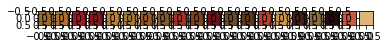

<Figure size 1440x1440 with 0 Axes>

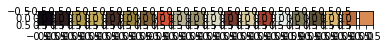

<Figure size 1440x1440 with 0 Axes>

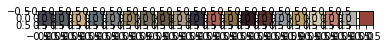

<Figure size 1440x1440 with 0 Axes>

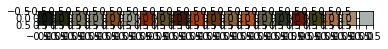

<Figure size 1440x1440 with 0 Axes>

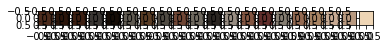

<Figure size 1440x1440 with 0 Axes>

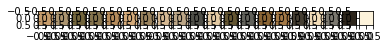

<Figure size 1440x1440 with 0 Axes>

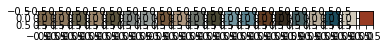

<Figure size 1440x1440 with 0 Axes>

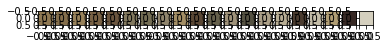

In [245]:
# spit a jpeg for each decade with the kmeans colours of each title
for decade in d_decades:
    print(decade)
    for title in d_decades[decade]:
        print(title)
        plt.figure(figsize=(20,20))

        fig, axs = plt.subplots(1, 20)

        l_ = d_decades[decade][title]    # list of dicts for the title
        # sort by occupation down
        l_ = sorted(l_, key=lambda d: d['occupation'],reverse=True)
        for i in range(20):
            print(l_[i])
            _ = axs[i].imshow(np.full((1,1,3), l_[i]['colour']));

        plt.savefig('colours_20_' + decade + '/' + title.split('.')[0] + '_colours.jpeg')

In [255]:
d_decades['1880']

{}

In [236]:
data

array([[11.6244039 ,  3.46713   , 16.83682015, 12.09934398, 15.17727766,
         0.51378802,  5.48534208, 16.31473254,  4.64972173,  3.27978638],
       [11.13847276, 16.93084413, 10.2415551 ,  2.23732427, 18.32590588,
        19.70538719,  4.75854738, 19.99413943,  2.16818373,  7.94997806],
       [ 2.35217326,  1.4025226 , 10.38568409,  5.17951055, 19.07901182,
        19.3233866 , 15.35105277, 16.64708453,  9.30843768, 12.43859931],
       [ 2.09187632,  0.92849605, 12.71162729, 13.12438397,  8.86263144,
         4.13323628,  8.7258948 , 19.94850572,  1.81651024,  7.88690222],
       [16.38567633,  4.61187408, 13.25967103,  0.44797796,  9.35938552,
         4.05065992, 15.1219138 ,  8.09832066,  6.11309954,  4.19947296],
       [12.40112782, 17.60086695,  9.09412138,  3.78351877, 15.62723381,
         4.61828838, 19.60987579,  0.51049105,  3.78644878, 12.09224788],
       [13.85071606, 16.29293354, 13.94802504,  5.45241954, 11.770041  ,
        14.1673583 ,  0.77303087, 10.15850093

In [251]:
# data = np.random.rand(10, 10) * 20

# # create discrete colormap
# cmap = colors.ListedColormap(['red', 'blue'])
# bounds = [0,10,20]
# norm = colors.BoundaryNorm(bounds, cmap.N)

# fig, ax = plt.subplots()
# ax.imshow(data, cmap=cmap, norm=norm);

# # draw gridlines
# ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
# ax.set_xticks(np.arange(-.5, 10, 1));
# ax.set_yticks(np.arange(-.5, 10, 1));

# plt.show()

## Other method: compare image to some palettes?

### Renoir's palette

What was Renoir's standard palette is info I got from [here](https://www.jacksonsart.com/blog/2014/08/12/colours-used-sargent-renoir/) and [here](https://webartacademy.com/renoirs-palette) (taken from this one really). 

The k-means methos is too coarse, gives us colours that are too similar painting by painting. Instead, what about we measure how much each painting is using of his palette.

The RGB of these colours have been chosen with a quick google search.

#### Some interesting videos about these colours:
* [flake white](https://www.youtube.com/watch?v=vx6BI3Fqr6U)

This won't do - too subjective, there's no green, plus it's his, so it is derived from his own paintings, hence circular reasoning

### A standard palette?


### Saturated colours + 

### Renoir's palette colours

<Figure size 720x720 with 0 Axes>

[236, 236, 236]
[250, 218, 94]
[255, 87, 51]
[35, 31, 32]
[128, 96, 67]
[245, 197, 44]
[247, 74, 70]
[200, 8, 21]
[0, 71, 171]
[184, 78, 112]


<Figure size 720x720 with 0 Axes>

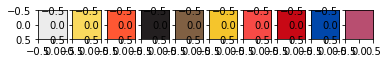

In [223]:
# renoir's palette
d_r_palette = {
    'flake_white':[236, 236, 236],
    'naples_yellow':[250 ,218, 94],
    'viridian':[255, 87, 51],
    'ivory_black':[35, 31, 32],
    'natural_earth':[128, 96, 67],
    'yellow_ochre':[245,197,44],
    'carmine':[247, 74, 70], # cannot find superfine carmine
    'venetian_red':[200, 8, 21],
    'cobalt_blue':[0, 71, 171],
    'lake_red':[184, 78, 112]
}

plt.figure(figsize=(10,10))

fig, axs = plt.subplots(1, 10)

l_ = list(d_r_palette.values())   # list of dicts for the title

for i in range(10):
    print(l_[i])
    _ = axs[i].imshow(np.full((1,1,3), l_[i]));

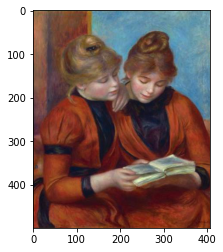

In [249]:
img = io.imread('renoir_1880/The Two Sisters(French: Les deux soeurs).jpeg')

plt.imshow(img)

In [260]:
# for row in img:
#     print(row)

## Trying image segmentation

with proper techniques, using this [lib](https://pypi.org/project/colour-segmentation/)

In [518]:
img = cv2.imread("renoir_1910/Portrait of Ambroise Vollard.jpeg")   # the lib is designed to work with OpenCV, so reading BGR
img = cv2.resize(img, (0,0), fx=0.2, fy=0.2)    # for speed

segmentator = Segmentator(image=img)

In [519]:
# result_liu = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_LIU,
#                                  apply_colour_correction=False,
#                                  remove_achromatic_colours=True)

result_amante_fonseca_achr = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_CHAMORRO,
                                                 remove_achromatic_colours=False)

In [520]:
result_amante_fonseca_achr.segmented_classes.max()
sum([result_amante_fonseca_achr.get_colour_proportion(i) for i in range(len(colours_cm))])
[result_amante_fonseca_achr.get_colour_proportion(i) for i in range(len(colours_cm))]
result_amante_fonseca_achr.get_colour_proportion(1)

11

1.0000000000000002

[0.008841423774104313,
 0.9111620733407759,
 0.050192565492443095,
 0.010076622683721828,
 0.006167027586856228,
 0.0030756677023506887,
 0.0009729152936007281,
 0.0006501046892723759,
 0.004131527387341341,
 0.0025824848346268177,
 0.0005761272591137953,
 0.0015714599557928811]

0.9111620733407759

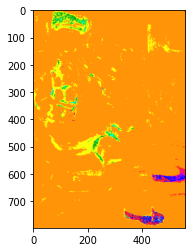

In [521]:
plt.imshow(cv2.cvtColor(result_amante_fonseca_achr.segmented_image, cv2.COLOR_BGR2RGB))

### Systematically and with all methods

Each method uses a different set of colours. The colours for each method are taken from the lib docs [here](https://mmunar97.gitbook.io/colour-segmentation/examples/examples-of-fuzzy-logic-based-methods)

We'll be useing each method with the flag that removes the achromatic colours (white, black, grey).

In [329]:
# Amante-Fonseca
colours_af = {
    0: [255, 33, 36],     # red
    1: [170, 121, 66],    # brown
    2: [255, 146, 0],      # orange
    3: [255, 251, 0],       # yellow
    4: [0, 255, 0],          # green
    5: [0, 253, 255],       # cyan
    6: [0, 0, 255],        # blue
    7: [147, 33, 146],     # purple
    8: [255, 64, 255]      # pink
}

# Chamorro - Martinez
colours_cm = {
    0: [255, 33, 36],     # red
    1: [255, 148, 9],      # orange
    2: [255, 255, 13],      # yellow
    3: [186, 255, 15],      # yellow-green
    4: [6, 155, 9],        # green
    5: [12, 255, 116],      # green-cyan
    6: [11, 254, 255],       # cyan
    7: [8, 192, 255],        # cyan-blue
    8: [0, 0, 255],         # blue
    9: [92, 8, 253],         # blue-magenta
    10: [238, 3, 249],       # magenta
    11: [254, 6, 180]        # magenta-red
}

# Liu-Wang
colours_lw = {
    0: [255, 33, 36],       # red
    1: [248, 149, 29],       #orange
    2: [239, 233, 17],       # yellow
    3: [105, 189, 69],        # green
    4: [111, 204, 221],       # cyan
    5: [59, 83, 164],          # blue
    6: [158, 80, 159]        # purple
}

# Shamir
colours_s = {
    0: [255, 33, 36],       # red
    1: [255, 140, 0],       # dark orange
    2: [255, 165, 0],        # light orange
    3: [255, 255, 0],        # yellow
    4: [144, 238, 144],      # light green
    5: [0, 100, 0],          # dark green
    6: [0, 255, 255],        # aqua
    7: [0, 0, 255],          # blue
    8: [128, 0, 128],        # dark purple
    9: [255, 0, 255]         # light purple
}

In [367]:
# run the same logic as in the example above on all imgs, save occupation to file
# run all segmentor

decades = ['1860', '1870', '1880', '1890', '1900', '1910']

d_af = {decade: {} for decade in decades}
d_cm = {decade: {} for decade in decades}
d_lw = {decade: {} for decade in decades}
d_s = {decade: {} for decade in decades}

for decade in decades:
    print(decade)
    for filename in os.listdir('renoir_{decade}'.format(decade=decade)):
        #print(filename)
        try:
        
            img = cv2.imread("renoir_{decade}/{filename}".format(decade=decade, filename=filename))  

            # resize for speed
            img = cv2.resize(img, (0,0), fx=0.2, fy=0.2) 

            d_af[decade][filename] = {}
            d_cm[decade][filename] = {}
            d_lw[decade][filename] = {}
            d_s[decade][filename] = {}

            # Amante-Fonseca
            segmentator = Segmentator(image=img)
            result_af = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_AMANTE,
                                            remove_achromatic_colours=False)   # I tried True but gives not-normalised values (sum if occupations isn't 1)
            for k in colours_af:
                d_af[decade][filename][k] = result_af.get_colour_proportion(k)

            # Chamorro-Martinez
            segmentator = Segmentator(image=img)
            result_cm = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_CHAMORRO,
                                            remove_achromatic_colours=False)
            for k in colours_cm:
                d_cm[decade][filename][k] = result_cm.get_colour_proportion(k)

            # Liu-Wang
            segmentator = Segmentator(image=img)
            result_lw = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_LIU,
                                            apply_colour_correction=False,
                                            remove_achromatic_colours=False)
            for k in colours_lw:
                d_lw[decade][filename][k] = result_lw.get_colour_proportion(k)

            # Shamir
            segmentator = Segmentator(image=img)
            result_s = segmentator.segment(method=SegmentationAlgorithm.FUZZY_SET_SHAMIR, 
                                           remove_achromatic_colours=False)
            for k in colours_s:
                d_s[decade][filename][k] = result_s.get_colour_proportion(k)
                
        except:
            pass

1860
1870
1880
1890
1900
1910


In [368]:
sum(d_af['1860']['Chalands sur la Seine (Barges on the Seine).jpeg'].values())

1.0

In [378]:
# d_lw['1880'].keys()
# sum(d_s['1880']['Blonde Bather (1881)(French: La baigneuse blonde).jpeg'].values())

In [400]:
len(d_af['1910'])

17

## Round up occupations

To 2 decimal digits - this is for ease of eye-balling

In [539]:
for decade in decades:
    for title in d_cm[decade]:
        for k in d_cm[decade][title]:
            d_cm[decade][title][k] = round(d_cm[decade][title][k], 2)

## Look at aggregated measures from this data

In [540]:
# eye-ball means of colours by decade for one of the colour methods

decade = '1860'
print(decade)
for k in colours_af:
    print(k, np.mean([d_af[decade][title][k] for title in d_af[decade]]), 
          np.std([d_af[decade][title][k] for title in d_af[decade]]))

decade = '1870'
print('\n', decade)
for k in colours_af:
    print(k, np.mean([d_af[decade][title][k] for title in d_af[decade]]), 
          np.std([d_af[decade][title][k] for title in d_af[decade]]))



1860
0 0.0634104970854697 0.045643155476797044
1 0.2203091453256199 0.13655744576930923
2 0.22504710121346722 0.12452302898469243
3 0.28506239807738043 0.14675633114614653
4 0.08169157384387649 0.09961879041085224
5 0.06167902817750956 0.06788293858009567
6 0.05144141528602256 0.06803751837117519
7 0.002410715223280053 0.004449614712667329
8 0.008948125767374134 0.016782520751405527

 1870
0 0.10223865401920121 0.10339626147983692
1 0.20263798966314672 0.1597122541996284
2 0.19587130758047697 0.14045625750058965
3 0.2083128992115915 0.18102323552697563
4 0.058070517373781334 0.0696931085204223
5 0.09435033252837606 0.1288158849744504
6 0.11404654819329858 0.13689596420667224
7 0.009951926001708673 0.013256406049127357
8 0.014519825428418948 0.017186140257893306


In [542]:
colours_cm

{0: [255, 33, 36],
 1: [255, 148, 9],
 2: [255, 255, 13],
 3: [186, 255, 15],
 4: [6, 155, 9],
 5: [12, 255, 116],
 6: [11, 254, 255],
 7: [8, 192, 255],
 8: [0, 0, 255],
 9: [92, 8, 253],
 10: [238, 3, 249],
 11: [254, 6, 180]}

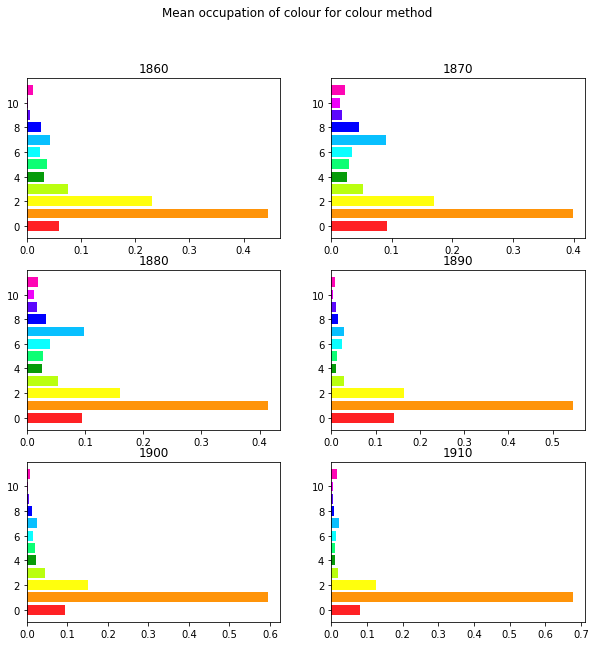

In [543]:
# plotting bars - these are coloured with the RGBs of the colour from colour method
d_plot = d_cm.copy()      # choose the colour method here
d_colours = colours_cm.copy()    # and the relative colours dict

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle('Mean occupation of colour for colour method')

decade = '1860'
x = [k for k in d_plot[decade][next(iter(d_plot[decade]))].keys()]
y =  [np.mean([d_plot[decade][title][k] for title in d_plot[decade]]) for k in x]
colours = [ tuple([item/255 for item in d_colours[i]]) for i in x]   # this must be a list of tuples, as per pyplot
axs[0,0].barh( x, y, color=colours)
axs[0,0].set_title(decade)

decade = '1870'
x = [k for k in d_plot[decade][next(iter(d_plot[decade]))].keys()]
y =  [np.mean([d_plot[decade][title][k] for title in d_plot[decade]]) for k in x]
colours = [ tuple([item/255 for item in d_colours[i]]) for i in x]   # this must be a list of tuples, as per pyplot
axs[0,1].barh( x, y , color=colours)
axs[0,1].set_title(decade)

decade = '1880'
x = [k for k in d_plot[decade][next(iter(d_plot[decade]))].keys()]
y =  [np.mean([d_plot[decade][title][k] for title in d_plot[decade]]) for k in x]
colours = [ tuple([item/255 for item in d_colours[i]]) for i in x] # this must be a list of tuples, as per pyplot
axs[1,0].barh( x, y , color=colours)
axs[1,0].set_title(decade)

decade = '1890'
x = [k for k in d_plot[decade][next(iter(d_plot[decade]))].keys()]
y =  [np.mean([d_plot[decade][title][k] for title in d_plot[decade]]) for k in x]
colours = [ tuple([item/255 for item in d_colours[i]]) for i in x] # this must be a list of tuples, as per pyplot
axs[1,1].barh( x, y , color=colours)
axs[1,1].set_title(decade)

decade = '1900'
x = [k for k in d_plot[decade][next(iter(d_plot[decade]))].keys()]
y =  [np.mean([d_plot[decade][title][k] for title in d_plot[decade]]) for k in x]
colours = [ tuple([item/255 for item in d_colours[i]]) for i in x] # this must be a list of tuples, as per pyplot
axs[2,0].barh( x, y , color=colours)
axs[2,0].set_title(decade)

decade = '1910'
x = [k for k in d_plot[decade][next(iter(d_plot[decade]))].keys()]
y =  [np.mean([d_plot[decade][title][k] for title in d_plot[decade]]) for k in x]
colours = [ tuple([item/255 for item in d_colours[i]]) for i in x] # this must be a list of tuples, as per pyplot
axs[2,1].barh( x, y , color=colours)
axs[2,1].set_title(decade)

plt.show();

#x, y, colours

In [544]:
# tot of titles processed for colour
len(d_af['1860'].keys()) + \
len(d_af['1870'].keys()) + \
len(d_af['1880'].keys()) + \
len(d_af['1890'].keys()) + \
len(d_af['1900'].keys()) + \
len(d_af['1910'].keys())

124

In [740]:
d_cm['1880'].keys()

dict_keys(['Children on the Seashore, Guernsey(French: Enfants au Bord de la Mer, Guernesey).jpeg', 'Luncheon of the Boating Party(French: Le déjeuner des canotiers).jpeg', 'Blonde Bather (1881)(French: La baigneuse blonde).jpeg', 'Two Sisters (On the Terrace)(French: Les deux sœurs (Sur la terrasse)).jpeg', 'Portrait of Charles and George Durand-Ruel(French: Portrait de Charles et George Durand-Ruel).jpeg', 'Woman Arranging her Hair(fr:Femme se coiffant).jpeg', "Woman with Fan(French: Femme à l'éventail).jpeg", 'Dance in the City(French: Danse dans la Ville).jpeg', 'Pink and Blue(Alice and Elisabeth Cahen d’Anvers).jpeg', 'Fruits of the Midi(French: Fruits du midi).jpeg', 'Still Life, Roses of Wargemont(French: Nature morte, Roses de Wargemont).jpeg', 'Young Girls in Black(French: Jeunes filles en noir).jpeg', 'By the Seashore(French: Femme Assise au Bord de la Mer).jpeg', 'A Young Girl with Daisies(French: Une jeune fille avec des marguerites).jpeg', 'Children on the Beach of Guernse

In [715]:
len(d_cm['1910'])

17

In [741]:
d_cm['1880']["Les grandes baigneuses(The Large Bathers).jpeg"]

{0: 0.11,
 1: 0.65,
 2: 0.09,
 3: 0.02,
 4: 0.01,
 5: 0.01,
 6: 0.01,
 7: 0.01,
 8: 0.03,
 9: 0.02,
 10: 0.01,
 11: 0.02}

In [742]:
df_1880s.iloc[:]

,Picture,Title,Year,Dimensions,Museum,original_filename
0,NaN,Two Sisters (On the Terrace)(French: Les deux ...,1881,100.5 cm × 81 cm (39.6 in × 31.9 in),"Art Institute of Chicago, Chicago, Illinois",8/8d/Renoir%2C_Pierre-Auguste_-_The_Two_Sister...
1,NaN,Mlle Irène Cahen d'Anvers,1880,65 cm × 54 cm (26 in × 21 in),"Foundation E.G. Bührle, Zurich, Switzerland[23]",e/ef/Mlle_Irene_Cahen_d%27Anvers.jpg
2,NaN,Sleeping Girl(French: Fille endormie),1880,120 cm × 94 cm (47 in × 37 in),"Clark Art Institute, Williamstown, Massachuset...",5/59/Pierre-August_Renoir_Sleeping_Girl_with_a...
3,NaN,Near the Lake(French: Près du lac),1880,47.5 cm × 56.4 cm (18.7 in × 22.2 in),"Art Institute of Chicago, Chicago, Illinois[25]",c/c5/Pierre-Auguste_Renoir_-_By_the_Water.jpg
4,NaN,"Venice, the Doge's Palace(French: Venise, le P...",1881,54.5 cm × 65 cm (21.5 in × 25.6 in),"Clark Art Institute, Williamstown, Massachuset...",9/9f/Renoir_Doges%27_Palace%2C_Venice.jpg
5,NaN,Luncheon of the Boating Party(French: Le déjeu...,1881,129.9 cm × 172.7 cm (51.1 in × 68.0 in),"The Phillips Collection, Washington, D.C.",8/8d/Pierre-Auguste_Renoir_-_Luncheon_of_the_B...
6,NaN,Blonde Bather (1881)(French: La baigneuse blonde),1881,82 cm × 66 cm (32 in × 26 in),Private collection,1/11/Renoir_Blond_Bather.jpg
7,NaN,Young Girls in Black(French: Jeunes filles en ...,1881,80 cm × 65 cm (31 in × 26 in),"Pushkin Museum, Moscow, Russia",2/2d/Jeunes_Filles_en_noir_by_Pierre-Auguste_R...
8,NaN,Pink and Blue(Alice and Elisabeth Cahen d’Anvers),1881,119 cm × 74 cm (47 in × 29 in),"São Paulo Museum of Art, São Paulo, Brazil",4/4c/Renoir_Mlles_Cahen_d_Anvers.jpg
9,NaN,Fruits of the Midi(French: Fruits du midi),1881,51 cm × 69 cm (20 in × 27 in),"Art Institute of Chicago, Chicago, Illinois, U...",b/b2/Pierre-Auguste_Renoir_141.jpg


## Other refs

* A nice [page](https://realpython.com/python-opencv-color-spaces/) on image segmentation with Python 
* [How to choose a palette for painting](https://www.artsy.net/article/artsy-editorial-4-colors-excel-painting)
* [The colour palettes of 10 famous paintings](https://www.haydnsymons.com/blog/the-colour-palettes-used-by-10-famous-paintings/)